In [12]:
import pandas as pd
import numpy as np

import wandb
import matplotlib.pyplot as plt
import dotenv

plt.rcParams.update({
    "font.family":       "serif",
    "font.serif":        ["Times New Roman", "Palatino", "STIX"],
    "mathtext.fontset":  "stix",
    "text.usetex":       False,

    "axes.labelsize":    14,
    "axes.titlesize":    16,
    "xtick.labelsize":   12,
    "ytick.labelsize":   12,
    "xtick.direction":   "out",
    "ytick.direction":   "out",

    "axes.grid":         False,
    "grid.color":        "0.8",
    "grid.linestyle":    "--",
    "grid.linewidth":    0.5,

    "legend.frameon":    True,
    "legend.framealpha": 0.9,
    "legend.edgecolor":  "0.8",
    "legend.fontsize":   12,

    "axes.facecolor":   "white",
    "figure.facecolor": "white",
    "savefig.facecolor":"white",

    "axes.spines.top":    False,
    "axes.spines.right":  False,
    "axes.spines.left":   True,
    "axes.spines.bottom": True,

    "errorbar.capsize": 5
})


api = wandb.Api(timeout=120)
dotenv.load_dotenv()

runs = api.runs(dotenv.get_key('../.env', 'WANDB_URL'), {"group": {"$regex": "runtime.*"}})

In [27]:
summary_list, config_list, name_list = [], [], []

memory = []
tasks = []
models = []
runtime = []
datasets = []
for run in runs:
    summary_list.append(run.summary._json_dict)
    memory.append(pd.Series(run.history(stream='events')['system.gpu.0.memoryAllocatedBytes']).interpolate(method="linear", limit_direction="both").tolist())

    config_list.append(
        {k: v for k,v in run.config.items()
         if not k.startswith('_')})
    name_list.append(run.name)
    tasks.append(run.config['task_name'])
    datasets.append(run.config['data_name'])
    models.append(run.config['model'])
    runtime.append(run.summary['_runtime'])

df = pd.DataFrame({
    'model': models,
    'data_name': datasets,
    'task_name': tasks,
    "memory": memory,
    "runtime": runtime,
})

df.head(10)

,model,data_name,task_name,memory,runtime
0,Graphormer,f1,driver-top3,"[43810750464.0, 34506735616.0, 25202720768.0, ...",355.531186
1,Graphormer,f1,driver-top3,"[29118103552.0, 29118103552.0, 29118103552.0, ...",352.858604
2,Graphormer,f1,driver-top3,"[20159070208.0, 23548067840.0, 26937065472.0, ...",350.855769
3,Graphormer,f1,driver-top3,"[38129565696.0, 38130264746.666664, 3813096379...",357.758009
4,FraudGT,avito,ad-ctr,"[1699938304.0, 1701336405.3333333, 1702734506....",163.141244
5,Graphormer,f1,driver-top3,"[16900096000.0, 16900096000.0, 16900096000.0, ...",354.698609
6,FraudGT,avito,ad-ctr,"[1702035456.0, 1703084032.0, 1704132608.0, 170...",166.761686
7,FraudGT,avito,ad-ctr,"[1699938304.0, 1700986880.0, 1702035456.0, 170...",163.854053
8,FraudGT,avito,ad-ctr,"[1699938304.0, 1701336405.3333333, 1702734506....",162.095901
9,FraudGT,avito,ad-ctr,"[1699938304.0, 1701336405.3333333, 1702734506....",162.580496


In [28]:
def mean(list_of_arrays):
    max_len = max(np.array(arr).shape[0] for arr in list_of_arrays)
    padded = [
        np.pad(arr,
               pad_width=(0, max_len - np.array(arr).shape[0]),
               constant_values=np.nan)
        for arr in list_of_arrays
    ]
    stacked = np.vstack(padded) * 1e-9
    return np.mean(np.nanmean(stacked, axis=0)), np.mean(np.nanstd(stacked, axis=0))

avg_memory = df.groupby(['model', 'task_name'])['memory'].apply(lambda lists: mean(lists)).apply(pd.Series).rename(columns={0: 'mean', 1: 'std'})
avg_memory = avg_memory.reset_index()
avg_memory.head()

,model,task_name,mean,std
0,FraudGT,ad-ctr,1.703780,0.000122
1,FraudGT,driver-dnf,1.699854,0.006506
2,FraudGT,driver-position,1.923949,0.003228
3,FraudGT,driver-top3,1.166501,0.005630
4,FraudGT,item-sales,1.605102,0.000529


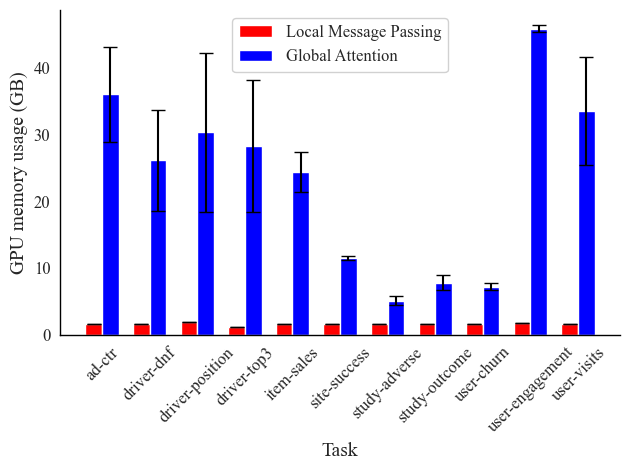

In [29]:
fraud_means = avg_memory[avg_memory['model'] == 'FraudGT']['mean']
fraud_std = avg_memory[avg_memory['model'] == 'FraudGT']['std']
graphormer_means = avg_memory[avg_memory['model'] == 'Graphormer']['mean']
graphormer_std = avg_memory[avg_memory['model'] == 'Graphormer']['std']


tasks = np.unique(avg_memory['task_name'].to_numpy().reshape((-1)))
# Plot
x = np.arange(len(tasks))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, fraud_means, width, label='Local Message Passing', color='red', yerr=fraud_std)
ax.bar(x + width/2, graphormer_means, width, label='Global Attention', color='blue', yerr=graphormer_std)


# Labels and aesthetics
ax.set_xticks(x)
ax.set_xticklabels(tasks, rotation=45)
ax.set_xlabel('Task')
ax.set_ylabel('GPU memory usage (GB)')
ax.legend()

plt.tight_layout()
plt.savefig('memory.pdf')
plt.show()

In [30]:
avg_runtime = df.groupby(['model', 'task_name'])['runtime'].mean().apply(pd.Series).reset_index().rename(columns={0: 'mean'})
std_runtime = df.groupby(['model', 'task_name'])['runtime'].std().apply(pd.Series).reset_index().rename(columns={0: 'std'})

In [31]:
avg_runtime.head()

,model,task_name,mean
0,FraudGT,ad-ctr,163.686676
1,FraudGT,driver-dnf,369.790639
2,FraudGT,driver-position,108.543296
3,FraudGT,driver-top3,99.840077
4,FraudGT,item-sales,1136.657179


In [32]:
std_runtime.head()

,model,task_name,std
0,FraudGT,ad-ctr,1.839524
1,FraudGT,driver-dnf,21.336140
2,FraudGT,driver-position,63.605643
3,FraudGT,driver-top3,1.656799
4,FraudGT,item-sales,5.151160


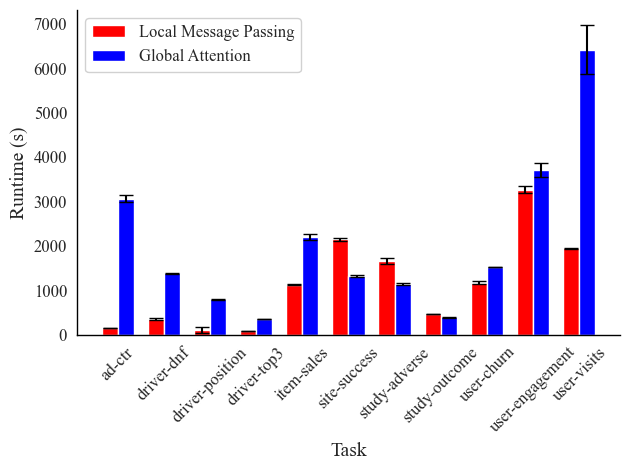

In [33]:
fraud_means = avg_runtime[avg_runtime['model'] == 'FraudGT']['mean']
fraud_std = std_runtime[std_runtime['model'] == 'FraudGT']['std']
graphormer_means = avg_runtime[avg_runtime['model'] == 'Graphormer']['mean']
graphormer_std = std_runtime[std_runtime['model'] == 'Graphormer']['std']

x = np.arange(len(tasks))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, fraud_means, width, label='Local Message Passing', color='red', yerr=fraud_std)
ax.bar(x + width/2, graphormer_means, width, label='Global Attention', color='blue', yerr=graphormer_std)


# Labels and aesthetics
ax.set_xticks(x)
ax.set_xticklabels(tasks, rotation=45)
ax.set_xlabel('Task')
ax.set_ylabel('Runtime (s)')
ax.legend()

plt.tight_layout()
plt.savefig('runtime.pdf')
plt.show()

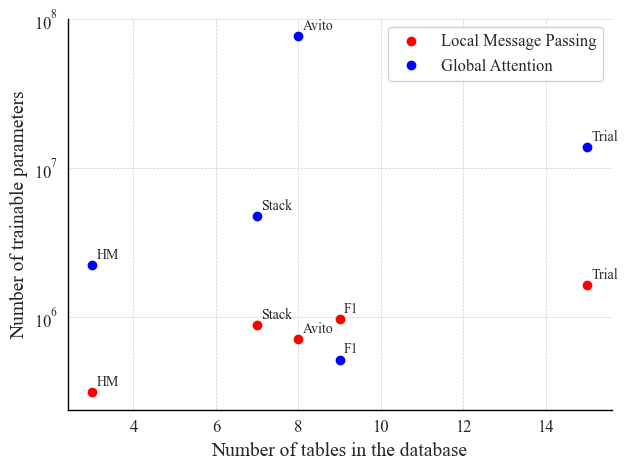

In [34]:
params_by_model = {
    'Local Message Passing': {
        'F1':968_293,
        'HM': 313_689,
        'Trial': 1_640_369,
        'Stack': 884_705,
        'Avito': 705_347,
    },
    'Global Attention': {
        'F1': 517_698,
        'HM': 2_217_810,
        'Trial': 13_831_394,
        'Stack': 4_773_362,
        'Avito': 76_348_674,
    },
}

tables = {
    'F1': 9,
    'HM': 3,
    'Trial': 15,
    'Stack': 7,
    'Avito': 8,
}

columns = {
    'F1': 77,
    'HM': 37,
    'Trial': 140,
    'Stack': 51,
    'Avito': 43,
}

colours = {
    'Local Message Passing': 'red',
    'Global Attention': 'blue',
}

plt.rcParams.update({
    "axes.edgecolor": "black",
    "axes.linewidth": 1.0,
})

for model, param_dict in params_by_model.items():
    x_vals = []
    y_vals = []
    labels = []
    for ds, param_count in param_dict.items():
        if param_count is not None:
            x_vals.append(tables[ds])
            y_vals.append(param_count)
            labels.append(ds)

    # plot all points for this model
    plt.scatter(x_vals, y_vals, label=model, color=colours[model])

    # annotate each point
    for x, y, ds in zip(x_vals, y_vals, labels):
        plt.annotate(
            ds,
            xy=(x, y),
            xytext=(3, 3),            # small offset
            textcoords="offset points",
            fontsize=10,
            ha="left",
            va="bottom"
        )

plt.xlabel("Number of tables in the database")
plt.ylabel("Number of trainable parameters")
plt.yscale("log")       # if you want log-scale
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('parameters_by_tables.pdf')
plt.show()

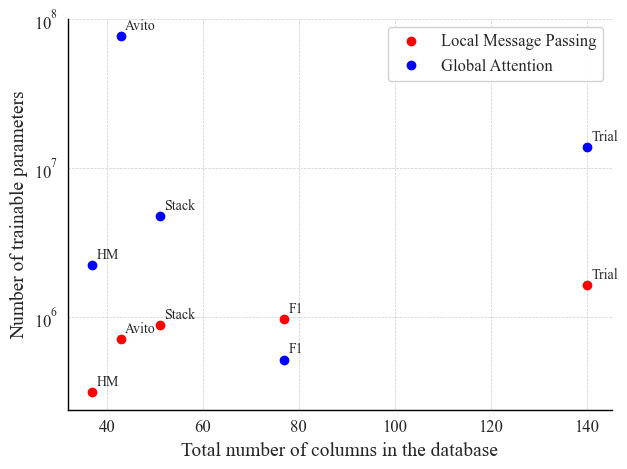

In [35]:
for model, param_dict in params_by_model.items():
    x_vals = []
    y_vals = []
    labels = []
    for ds, param_count in param_dict.items():
        if param_count is not None:
            x_vals.append(columns[ds])
            y_vals.append(param_count)
            labels.append(ds)

    # plot all points for this model
    plt.scatter(x_vals, y_vals, label=model, color=colours[model])

    # annotate each point
    for x, y, ds in zip(x_vals, y_vals, labels):
        plt.annotate(
            ds,
            xy=(x, y),
            xytext=(3, 3),            # small offset
            textcoords="offset points",
            fontsize=10,
            ha="left",
            va="bottom"
        )

plt.xlabel("Total number of columns in the database")
plt.ylabel("Number of trainable parameters")
plt.yscale("log")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('parameters_by_columns.pdf')
plt.show()

In [36]:
x = np.array([9, 3, 15, 8, 7])
y = np.array([968_293, 313_689, 1_640_369, 705_347, 884_705])

r = np.corrcoef(x, y)[0, 1]
r

np.float64(0.9772234268815095)